In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
user_events = pd.read_csv('Encrypted Datasets/filtered_user_events.csv')
user_segments = pd.read_csv('Encrypted Datasets/user_segment_slice.csv')
body_users = pd.read_csv('Encrypted Datasets/body_users.csv')

In [8]:
user_events_with_original = pd.read_csv('Encrypted Datasets/user_events_with_original.csv')

In [12]:
user_id_mapping = pd.read_csv('Encrypted Datasets/user_id_mapping.csv')
user_segment_agg = pd.read_csv('Encrypted Datasets/user_segment_agg.csv')

In [47]:
# Новый список этапов онбординга
onboarding_events = [
    'Initiated account registration',
    'Mobile number verification completed',
    'Mobile number was linked to the account', 
    'Email verification',
    'Personal data submitted',
    'User profile status changed',
    'Fourth stage finalized',
    'Fifth stage finalized',
    'User profile verified',
    'Account contract signed',
    'Unable to create account',
    'Account registered under a personal name',
    'Account documents submitted',
    'Account created for a business or organization',
    'Referral enrollment finalized',
    'Account set up through a mobile device',
    'Account setup completed successfully',
    'User role updated',
    'Account successfully created for user',
    'Account opened successfully',
    'User session established',
    'Chosen a pricing plan for the accoun',
    'Switched to live environment',
    'IPO participation option selected'
]

print(f"Всего этапов онбординга: {len(onboarding_events)}")

Всего этапов онбординга: 24


In [49]:
# Сначала получим все уникальные события в данных
all_events = user_events_with_original['name'].unique()
non_onboarding_events = set(all_events) - set(onboarding_events)

print(f"Всего событий в данных: {len(all_events)}")
print(f"Событий онбординга: {len(onboarding_events)}")
print(f"Событий НЕ онбординга: {len(non_onboarding_events)}")

# Создаем матрицу для каждого original_user_id
onboarding_matrix = user_events_with_original.groupby('original_client_user_id').apply(
    lambda x: pd.Series({f'completed_{event}': 1 if event in x['name'].values else 0 
                        for event in onboarding_events})
).reset_index()

print(f"Пользователей в матрице онбординга: {len(onboarding_matrix)}")

# Добавляем флаг - есть ли у пользователя действия вне онбординга
user_non_onboarding_activity = user_events_with_original.groupby('original_client_user_id').apply(
    lambda x: any(event in non_onboarding_events for event in x['name'].values)
).reset_index(name='has_non_onboarding_activity')

onboarding_matrix = onboarding_matrix.merge(
    user_non_onboarding_activity,
    on='original_client_user_id',
    how='left'
)

# Если есть действия вне онбординга - считаем онбординг пройденным
onboarding_matrix['onboarding_passed'] = onboarding_matrix['has_non_onboarding_activity']

# Добавляем общее количество пройденных этапов
onboarding_matrix['total_completed_steps'] = onboarding_matrix[
    [col for col in onboarding_matrix.columns if col.startswith('completed_')]
].sum(axis=1)

print("Распределение по количеству пройденных этапов:")
print(onboarding_matrix['total_completed_steps'].value_counts().sort_index())

print(f"\nПользователей, прошедших онбординг: {onboarding_matrix['onboarding_passed'].sum()}")
print(f"Пользователей, НЕ прошедших онбординг: {len(onboarding_matrix) - onboarding_matrix['onboarding_passed'].sum()}")

Всего событий в данных: 95
Событий онбординга: 24
Событий НЕ онбординга: 76


C:\Users\Adil\AppData\Local\Temp\ipykernel_3664\470204826.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  onboarding_matrix = user_events_with_original.groupby('original_client_user_id').apply(


Пользователей в матрице онбординга: 210103
Распределение по количеству пройденных этапов:
total_completed_steps
0     159230
1       1580
2        142
3         77
4        998
5       2931
6       1807
7        327
8        237
9      35634
10      6390
11       671
12        67
13        11
14         1
Name: count, dtype: int64

Пользователей, прошедших онбординг: 210074
Пользователей, НЕ прошедших онбординг: 29


C:\Users\Adil\AppData\Local\Temp\ipykernel_3664\470204826.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_non_onboarding_activity = user_events_with_original.groupby('original_client_user_id').apply(


In [50]:
# Определяем порядок этапов для анализа последовательности
event_order = {event: i for i, event in enumerate(onboarding_events)}

# Находим последний пройденный этап для каждого пользователя
def find_last_completed_event(row):
    # Если пользователь прошел онбординг (есть не-онбординг активность), 
    # то считаем что он прошел все этапы
    if row['onboarding_passed']:
        return 'Onboarding completed successfully'
    
    # Иначе находим последний пройденный этап
    last_event = None
    last_index = -1
    
    for event in onboarding_events:
        if row[f'completed_{event}'] == 1:
            event_index = event_order[event]
            if event_index > last_index:
                last_index = event_index
                last_event = event
                
    return last_event if last_event else 'No onboarding steps completed'

onboarding_matrix['last_completed_event'] = onboarding_matrix.apply(find_last_completed_event, axis=1)

# Анализируем точки выпадения
drop_points = onboarding_matrix['last_completed_event'].value_counts()

print("ТОЧКИ ВЫПАДЕНИЯ ИЗ ОНБОРДИНГА:")
print("=" * 70)
for event, count in drop_points.items():
    percentage = (count / len(onboarding_matrix)) * 100
    print(f"{event:<40} {count} пользователей ({percentage:.1f}%)")

ТОЧКИ ВЫПАДЕНИЯ ИЗ ОНБОРДИНГА:
Onboarding completed successfully        210074 пользователей (100.0%)
Account successfully created for user    20 пользователей (0.0%)
Account set up through a mobile device   4 пользователей (0.0%)
User session established                 2 пользователей (0.0%)
Chosen a pricing plan for the accoun     2 пользователей (0.0%)
Unable to create account                 1 пользователей (0.0%)


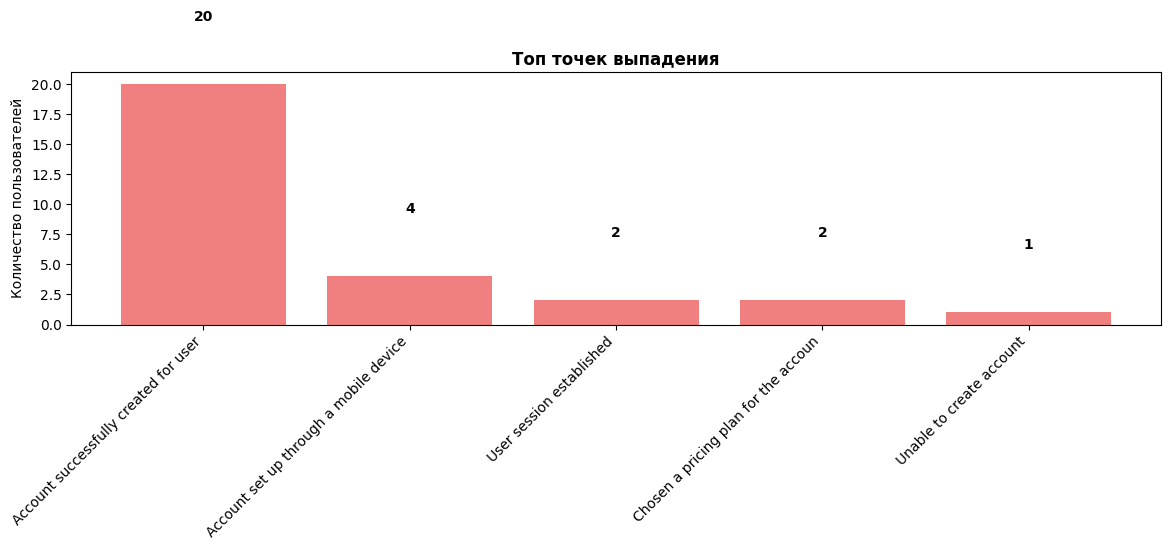

In [52]:
# Визуализация статуса онбординга
plt.figure(figsize=(12, 6))

failed_onboarding = onboarding_matrix[~onboarding_matrix['onboarding_passed']]
drop_points_failed = failed_onboarding['last_completed_event'].value_counts().head(8)

bars = plt.bar(drop_points_failed.index, drop_points_failed.values, color='lightcoral')
plt.title('Топ точек выпадения', fontweight='bold')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45, ha='right')

# Добавляем числа на столбцы
for bar, count in zip(bars, drop_points_failed.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{count}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [53]:
# Анализируем только пользователей, которые не прошли онбординг
failed_users = onboarding_matrix[~onboarding_matrix['onboarding_passed']]

print("ДЕТАЛЬНЫЙ АНАЛИЗ НЕУСПЕШНЫХ ПОЛЬЗОВАТЕЛЕЙ:")
print("=" * 70)
print(f"Всего неуспешных пользователей: {len(failed_users)}")

# Анализируем прогресс неуспешных пользователей
failed_progress = failed_users[[col for col in failed_users.columns if col.startswith('completed_')]].mean() * 100

print("\nПРОЦЕНТ ЗАВЕРШЕНИЯ ЭТАПОВ У НЕУСПЕШНЫХ ПОЛЬЗОВАТЕЛЕЙ:")
for event, rate in failed_progress.sort_values(ascending=False).items():
    if rate > 0:  # Показываем только этапы, которые были пройдены
        event_name = event.replace('completed_', '')
        print(f"{event_name:<40} {rate:.1f}%")

# Анализируем пользователей без единого этапа
no_steps_users = failed_users[failed_users['total_completed_steps'] == 0]
print(f"\nПользователей без единого пройденного этапа: {len(no_steps_users)} ({(len(no_steps_users)/len(failed_users)*100):.1f}%)")

# Анализируем пользователей с частичным прохождением
partial_users = failed_users[failed_users['total_completed_steps'] > 0]
print(f"Пользователей с частичным прохождением: {len(partial_users)} ({(len(partial_users)/len(failed_users)*100):.1f}%)")

ДЕТАЛЬНЫЙ АНАЛИЗ НЕУСПЕШНЫХ ПОЛЬЗОВАТЕЛЕЙ:
Всего неуспешных пользователей: 29

ПРОЦЕНТ ЗАВЕРШЕНИЯ ЭТАПОВ У НЕУСПЕШНЫХ ПОЛЬЗОВАТЕЛЕЙ:
Account set up through a mobile device   82.8%
Initiated account registration           75.9%
Account setup completed successfully     75.9%
Account successfully created for user    75.9%
User profile status changed              72.4%
Unable to create account                 13.8%
Chosen a pricing plan for the accoun     6.9%
User session established                 6.9%

Пользователей без единого пройденного этапа: 0 (0.0%)
Пользователей с частичным прохождением: 29 (100.0%)


In [61]:
# Если проблема persists, пересоздадим с правильным объединением

# 1. Сначала получим уникальных пользователей из onboarding_matrix
onboarding_matrix_unique = onboarding_matrix.drop_duplicates(subset=['original_client_user_id'])

# 2. Получим демографические данные без дубликатов
body_users_unique = body_users.drop_duplicates(subset=['original_client_user_id'])

# 3. Объединим правильно
onboarding_with_channels_corrected = onboarding_matrix_unique.merge(
    body_users_unique[['original_client_user_id', 'Канал привлечения', 'sex_type', 'age_segment']],
    on='original_client_user_id',
    how='left'
)

# 4. Добавим сегменты активов
user_segment_unique = user_segments.drop_duplicates(subset=['original_client_user_id'])
onboarding_with_channels_corrected = onboarding_with_channels_corrected.merge(
    user_segment_unique[['original_client_user_id', 'user_segment_in_reception_id']],
    on='original_client_user_id',
    how='left'
)


print(f"Корректный размер onboarding_with_channels: {len(onboarding_with_channels_corrected)}")
print(f"Уникальных original_user_id: {onboarding_with_channels_corrected['original_client_user_id'].nunique()}")

Корректный размер onboarding_with_channels: 210103
Уникальных original_user_id: 210103


In [62]:
# Фильтруем только неуспешных пользователей
failed_users = onboarding_with_channels_corrected[~onboarding_with_channels_corrected['onboarding_passed']]

print("АНАЛИЗ КАНАЛОВ ПРИВЛЕЧЕНИЯ ДЛЯ НЕУСПЕШНЫХ ПОЛЬЗОВАТЕЛЕЙ:")
print("=" * 80)
print(f"Всего неуспешных пользователей: {len(failed_users)}")

# Анализируем распределение по каналам
channel_distribution = failed_users['Канал привлечения'].value_counts()
channel_percentage = (channel_distribution / len(failed_users)) * 100

print("\nРАСПРЕДЕЛЕНИЕ ПО КАНАЛАМ ПРИВЛЕЧЕНИЯ:")
print("=" * 50)
for channel, count in channel_distribution.items():
    percentage = channel_percentage[channel]
    print(f"{channel:<40} {count} пользователей ({percentage:.1f}%)")

# Топ-10 каналов с наибольшим количеством неудач
top_failed_channels = channel_distribution.head(10)

АНАЛИЗ КАНАЛОВ ПРИВЛЕЧЕНИЯ ДЛЯ НЕУСПЕШНЫХ ПОЛЬЗОВАТЕЛЕЙ:
Всего неуспешных пользователей: 29

РАСПРЕДЕЛЕНИЕ ПО КАНАЛАМ ПРИВЛЕЧЕНИЯ:
Органика                                 21 пользователей (72.4%)
Маркетинг KZ                             5 пользователей (17.2%)
Рефералка Sales                          3 пользователей (10.3%)


In [63]:
# Разделяем пользователей на прошедших и не прошедших онбординг
passed_onboarding = onboarding_with_channels_corrected[onboarding_with_channels_corrected['onboarding_passed'] == True]
failed_onboarding = onboarding_with_channels_corrected[onboarding_with_channels_corrected['onboarding_passed'] == False]

print(f"Прошедших онбординг: {len(passed_onboarding)}")
print(f"Не прошедших онбординг: {len(failed_onboarding)}")

# Анализируем распределение по каналам для обеих групп
channel_distribution_passed = passed_onboarding['Канал привлечения'].value_counts(normalize=True) * 100
channel_distribution_failed = failed_onboarding['Канал привлечения'].value_counts(normalize=True) * 100

# Берем топ-10 каналов для визуализации
top_channels = channel_distribution_passed.head(10).index

# Фильтруем только топ каналы для сравнения
channel_comparison = pd.DataFrame({
    'Прошли_онбординг': channel_distribution_passed[top_channels],
    'Не_прошли_онбординг': channel_distribution_failed[top_channels]
}).fillna(0)  # Заполняем нулями, если канала нет в одной из групп

print("ТОП КАНАЛОВ ПРИВЛЕЧЕНИЯ:")
print("=" * 50)
print(channel_comparison.round(1))

Прошедших онбординг: 210074
Не прошедших онбординг: 29
ТОП КАНАЛОВ ПРИВЛЕЧЕНИЯ:
                   Прошли_онбординг  Не_прошли_онбординг
Канал привлечения                                       
Органика                       45.3                 72.4
Маркетинг KZ                   31.7                 17.2
Рефералка Sales                23.0                 10.3


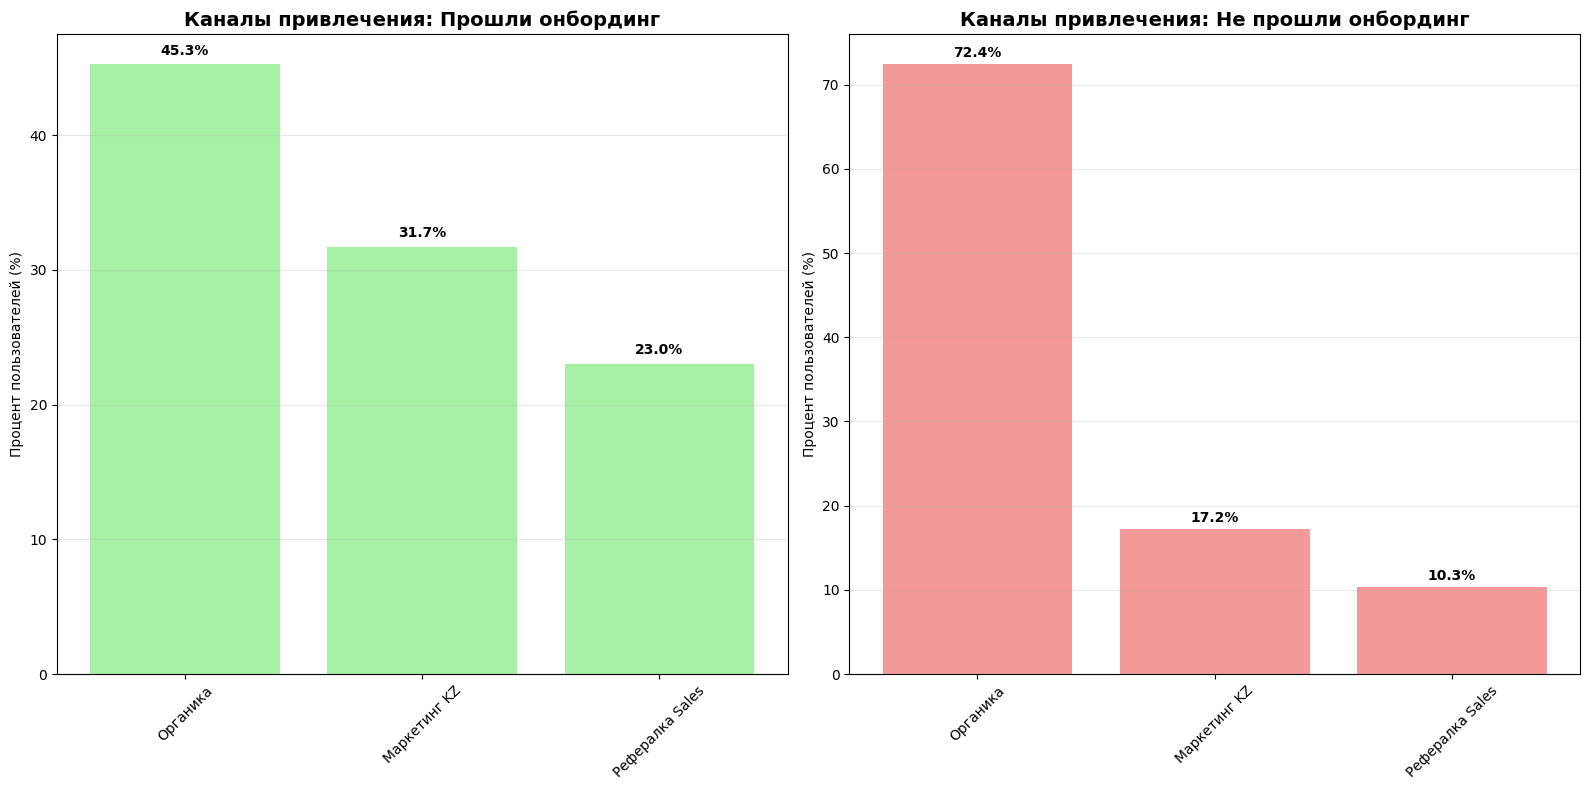

In [66]:
# Создаем фигуру с двумя subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# 1. Bar plot для прошедших онбординг
bars1 = ax1.bar(channel_comparison.index, channel_comparison['Прошли_онбординг'], 
                color='lightgreen', alpha=0.8)
ax1.set_title('Каналы привлечения: Прошли онбординг', fontweight='bold', fontsize=14)
ax1.set_ylabel('Процент пользователей (%)')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Добавляем числа на столбцы
for bar, percentage in zip(bars1, channel_comparison['Прошли_онбординг']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold')

# 2. Bar plot для не прошедших онбординг
bars2 = ax2.bar(channel_comparison.index, channel_comparison['Не_прошли_онбординг'], 
                color='lightcoral', alpha=0.8)
ax2.set_title('Каналы привлечения: Не прошли онбординг', fontweight='bold', fontsize=14)
ax2.set_ylabel('Процент пользователей (%)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# Добавляем числа на столбцы
for bar, percentage in zip(bars2, channel_comparison['Не_прошли_онбординг']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

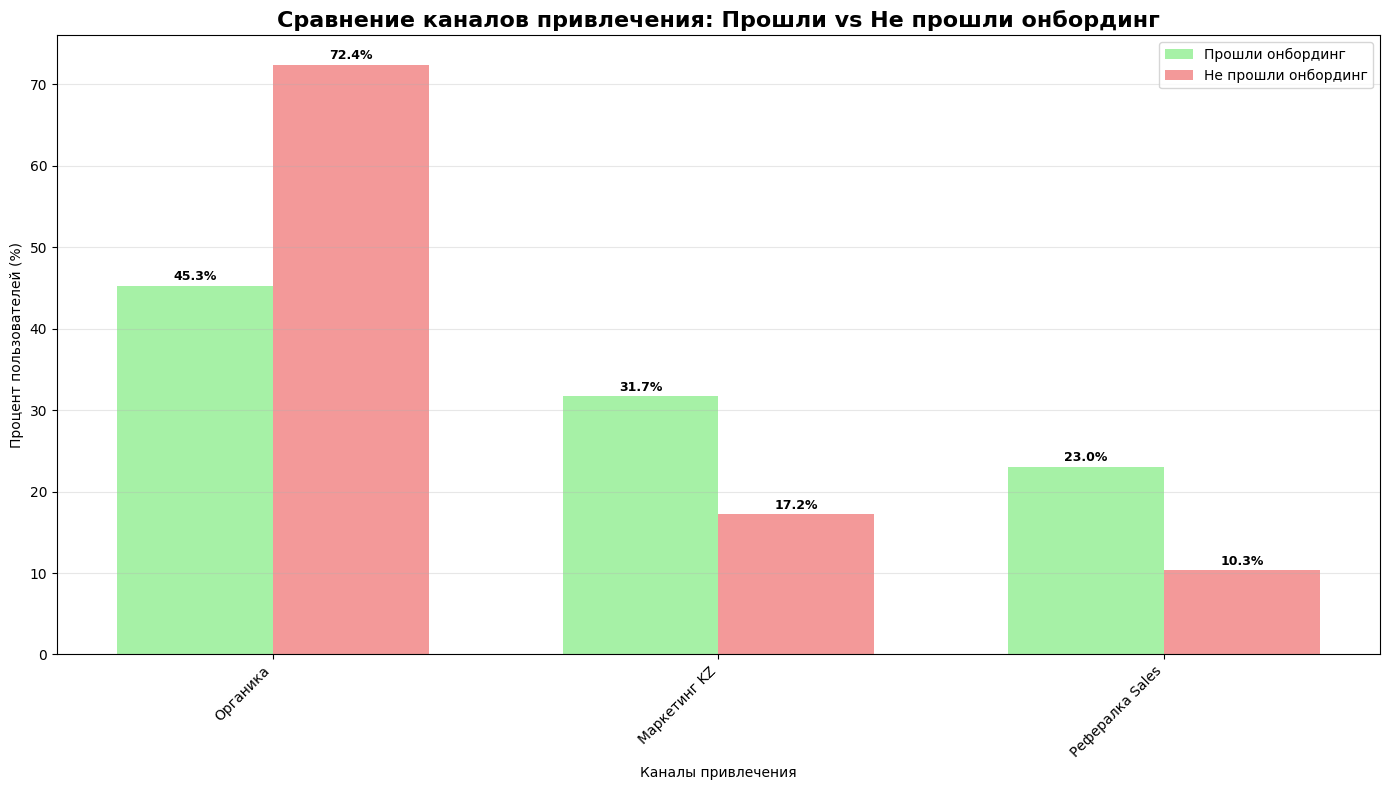

In [65]:
# Создаем сравнительный bar plot
plt.figure(figsize=(14, 8))

x = np.arange(len(channel_comparison))
width = 0.35

bars1 = plt.bar(x - width/2, channel_comparison['Прошли_онбординг'], width, 
                label='Прошли онбординг', color='lightgreen', alpha=0.8)
bars2 = plt.bar(x + width/2, channel_comparison['Не_прошли_онбординг'], width, 
                label='Не прошли онбординг', color='lightcoral', alpha=0.8)

plt.title('Сравнение каналов привлечения: Прошли vs Не прошли онбординг', 
          fontweight='bold', fontsize=16)
plt.ylabel('Процент пользователей (%)')
plt.xlabel('Каналы привлечения')
plt.xticks(x, channel_comparison.index, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Добавляем числа на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                 f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()